#LIBRARIES IMPORT, FUNCTION DEFINITION AND DATA LOADING

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
"""
LIBRARIES IMPORT AND CONSTANTS DEFINITION
A seed is used to make training-validation split reproducible.
"""

import os

import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend #for clearing gpu and memory
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

import matplotlib.pyplot as plt
import numpy as np

BASE_DIR = '/content/gdrive/My Drive/Quintavalla/'
DATA_FOLDER = BASE_DIR + "numpy data"
MODELS_FOLDER = BASE_DIR + "models"

MAX_UINT16 = 65535
VALIDATION_SPLIT = 0.15
DEFAULT_NUMBER_OF_EPOCHS = 50
MAX_NUMBER_OF_EPOCHS = 200
DEFAULT_BATCH_SIZE = 32
SEED = 21

os.environ["PYTHONHASHSEED"]=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
"""
FUNCTION DEFINITION: DATA LOADING
The following functions load training and test data from the respective files. A 
dimension is added for compatibility with Keras models. Since in this task 
baselines are not required, the corresponding images and labels are discarded. 
"""

def load_training_data():
  images = np.load(os.path.join(DATA_FOLDER, 'train_tensor.npy'))
  labels = np.load(os.path.join(DATA_FOLDER, 'train_labels.npy'))
  images = np.expand_dims(images, axis=3)
  not_baseline_indexes = np.where(labels != 0)
  return images[not_baseline_indexes], labels[not_baseline_indexes]

def load_test_data():
  images = np.load(os.path.join(DATA_FOLDER, 'public_test_tensor.npy'))
  labels = np.load(os.path.join(DATA_FOLDER, 'public_test_labels.npy'))
  images = np.expand_dims(images, axis=3)
  not_baseline_indexes = np.where(labels != 0)
  return images[not_baseline_indexes], labels[not_baseline_indexes]

In [ ]:
"""
FUNCTION DEFINITION: ACCURACY/LOSS PLOTTING
The following functions plot training vs. validation accuracy and training vs. 
validation loss.
"""

def plot_training_validation_accuracy(training_accuracy, validation_accuracy):

  epochs = [ x+1 for x in range(len(training_accuracy)) ]

  plt.plot(epochs, training_accuracy, 'r', label="Training Accuracy")
  plt.plot(epochs, validation_accuracy, 'b', label="Validation Accuracy")
  plt.ylim(0, 1)
  plt.xticks(np.arange(min(epochs)-1, max(epochs)+1, 5.0))
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.show()

def plot_training_validation_loss(training_loss, validation_loss):

  epochs = [ x+1 for x in range(len(training_loss)) ]

  plt.plot(epochs, training_loss, 'r', label="Training Loss")
  plt.plot(epochs, validation_loss, 'b', label="Validation Loss")
  plt.xticks(np.arange(min(epochs)-1, max(epochs)+1, 5.0))
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.show()

In [ ]:
"""
DATA LOADING
Data are loaded from files using functions defined above. 
"""

training_images, training_labels = load_training_data()
test_images, test_labels = load_test_data()

print(training_images.shape)
print(training_labels.shape)

print(test_images.shape)
print(test_labels.shape)

print(training_labels)
print(test_labels)

print(training_images.dtype)

TRAINING_SET_SIZE = training_images.shape[0]
TEST_SET_SIZE = test_images.shape[0]
IMAGE_HEIGHT = training_images.shape[1]
IMAGE_WIDTH =  training_images.shape[2]
CHANNELS = training_images.shape[3]

(2676, 150, 150, 1)
(2676,)
(336, 150, 150, 1)
(336,)
[2 2 1 ... 4 4 3]
[2 2 2 2 1 1 2 2 1 2 2 1 1 2 2 2 2 2 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 1 1 1 1 2 2 1 1 2 2 2 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 2 2 1
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2
 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 2 2 1 2 2 1 2 1
 1 1 1 2 2 1 1 1 1 1 2 2 2 1 1 2 2 1 2 2 1 1 1 1 2 2 1 1 1 1 1 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 4 3 3 3 3 4 4 3 3 3 3
 3 3 4 3 3 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 3 3 4 4 3 3 4 4 4 4 4 4
 4 3 3 3 3 4 4 4 3 3 3 3 3 3 4 3 3 3 3 3 3 4 4 4 4 3 3 3 3 4 3 3 4 4 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 4 4 4 4 4 4 3 3 4 4 4 4 4 4 4 3 3 3 3 3 3 3
 3 3 3]
uint16


#SUBTASK 1: FROM-SCRATCH CALCIFICATION-MASS CLASSIFICATION
Since the problem is a binary classification, we need to distinguish between two classes. Label 0 is assigned to Calcification class (original labels were 3 and 4), label 1 is assigned to Mass class (original labels were 1 and 2). It is important to analyze the balancing of the two classes so that a countermeasure to a possible unbalanced class problem can be taken. 

In [ ]:
"""
PREPROCESSING
Labels are redefined: label 0 is assigned to Calcification class, label 1 is assigned to Mass class.
Sets compositions are printed.
"""

cm_training_labels = np.array([0 if n > 2 else 1 for n in training_labels]) 
cm_test_labels = np.array([0 if n > 2 else 1 for n in test_labels]) 

print("TRAINING SET")
print("Number of samples of class 0 (Calcification): " + str(np.count_nonzero(cm_training_labels==0)) + 
      " (" + str(round((np.count_nonzero(cm_training_labels==0)/TRAINING_SET_SIZE)*100,2)) + "%)")
print("Number of samples of class 1 (Mass): " + str(np.count_nonzero(cm_training_labels==1)) + 
      " (" + str(round((np.count_nonzero(cm_training_labels==1)/TRAINING_SET_SIZE)*100,2)) + "%)")

print("TEST SET")
print("Number of samples of class 0 (Calcification): " + str(np.count_nonzero(cm_test_labels==0)) + 
      " (" + str(round((np.count_nonzero(cm_test_labels==0)/TEST_SET_SIZE)*100,2)) + "%)")
print("Number of samples of class 1 (Mass): " + str(np.count_nonzero(cm_test_labels==1)) + 
      " (" + str(round((np.count_nonzero(cm_test_labels==1)/TEST_SET_SIZE)*100,2)) + "%)")

best_model1 = None
best_accuracy1 = 0
best_loss1 = 100

TRAINING SET
Number of samples of class 0 (Calcification): 1458 (54.48%)
Number of samples of class 1 (Mass): 1218 (45.52%)
TEST SET
Number of samples of class 0 (Calcification): 157 (46.73%)
Number of samples of class 1 (Mass): 179 (53.27%)


As shown, the two classes are equally proportioned, so no countermeasure is necessary.

##EXPERIMENT 1_1: A QUICK TEST TO FIND A PROMISING MODEL
The aim of this experiment is to find a promising model, namely a model whose accuracy and loss on the test set are satisfying. The experiment is perfomed without data augmentation, early stopping and regularization and with a fixed set of hyperparameters (*batch_size=32*, *number_of_epochs=50*, *optimizer=Adam*, *learning_rate=1e-4*). *Binary Crossentropy* is used as loss function. 

In [ ]:
"""
PREPROCESSING
Training and test images are normalized. Training images (and their respective labels) are 
shuffled because the parameter validation_split of model.fit function will take the last portion 
of the dataset as validation set. To the current state, images (and their labels) are ordered by 
class (the elements labelled as 0 are at the end of the set). Validation set composition is
printed, so that a new extraction can be performed in case of unbalanced classes.
"""

m1_1_training_images = training_images / MAX_UINT16
m1_1_training_labels = cm_training_labels

m1_1_test_images = test_images / MAX_UINT16
m1_1_test_labels = cm_test_labels

# permutation is used in order to perform the same shuffling on images and labels
permutation = np.random.RandomState(seed=SEED).permutation(TRAINING_SET_SIZE)   
m1_1_training_images = m1_1_training_images[permutation]  
m1_1_training_labels = m1_1_training_labels[permutation] 

m1_1_validation_size = int(np.floor(TRAINING_SET_SIZE*VALIDATION_SPLIT))
m1_1_validation_labels = m1_1_training_labels[-m1_1_validation_size:]

print("VALIDATION SET")
print("Number of samples of class 0 (Calcification): " + str(np.count_nonzero(m1_1_validation_labels==0)) + 
      " (" + str(round((np.count_nonzero(m1_1_validation_labels==0)/m1_1_validation_size)*100,2)) + "%)")
print("Number of samples of class 1 (Mass): " + str(np.count_nonzero(m1_1_validation_labels==1)) + 
      " (" + str(round((np.count_nonzero(m1_1_validation_labels==1)/m1_1_validation_size)*100,2)) + "%)")

VALIDATION SET
Number of samples of class 0 (Calcification): 220 (54.86%)
Number of samples of class 1 (Mass): 181 (45.14%)


Validation set is equally balanced.

### MODEL 1_1_A
For this model I took inspiration from AlexNet. The model is made up by 5 Convolutional Layers, 3 Max Pooling Layers, a Flatten Layer and 3 Dense Layers (the last one performs the classification step). However, the total number of weights is drastically reduced (from 62M to 1M), so the the model is easy to train. Talking about activation functions, *ReLu* is used in convolutional layers in order to avoid Vanishing Gradient Problem. *Sigmoid* is used as activation function in the last layer. 







In [ ]:
"""
MODEL 1_1_A CREATION
"""

model1_1_a = models.Sequential(name="MODEL1_1_A")
model1_1_a.add(layers.Conv2D(filters=32, kernel_size=(9,9), strides=3, activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
model1_1_a.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="MAX_POOL_1"))
model1_1_a.add(layers.Conv2D(filters=96, kernel_size=(5,5), padding="same", activation='relu', name="CONV_2"))
model1_1_a.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="MAX_POOL_2"))
model1_1_a.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', name="CONV_3"))
model1_1_a.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', name="CONV_4"))
model1_1_a.add(layers.Conv2D(filters=96, kernel_size=(3, 3), padding="same", activation='relu', name="CONV_5"))
model1_1_a.add(layers.MaxPooling2D(pool_size=(3, 3), strides=2, name="MAX_POOL_3"))
model1_1_a.add(layers.Flatten(name="FLAT_1"))
model1_1_a.add(layers.Dense(units=256, activation='relu', name="DENSE_1"))
model1_1_a.add(layers.Dense(units=256, activation='relu', name="DENSE_2"))
model1_1_a.add(layers.Dense(units=1, activation='sigmoid', name="DENSE_3"))

model1_1_a.summary()

Model: "MODEL1_1_A"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 48, 48, 32)        2624      
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 24, 24, 32)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 24, 24, 96)        76896     
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 12, 12, 96)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 12, 12, 128)       110720    
_________________________________________________________________
CONV_4 (Conv2D)              (None, 12, 12, 128)       147584    
_________________________________________________________________
CONV_5 (Conv2D)              (None, 12, 12, 96)        1

In [ ]:
"""
MODEL 1_1_A COMPILATION AND FITTING
A predefined set of Hyperparameters is used for compiling the model (Adam+1e-4 as
optimizer, binary_crossentropy as loss function) and for training it (32 as
batch size, 50 as epochs, 0.15 as validation_split).
"""

model1_1_a.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1_1_a_history = model1_1_a.fit(x=m1_1_training_images,
          y=m1_1_training_labels, 
          epochs=DEFAULT_NUMBER_OF_EPOCHS,
          batch_size=DEFAULT_BATCH_SIZE,
          validation_split=VALIDATION_SPLIT,
          shuffle=True)

Epoch 1/50
72/72 [==============================] - 8s 15ms/step - loss: 0.6908 - accuracy: 0.5540 - val_loss: 0.6833 - val_accuracy: 0.5473
Epoch 2/50
72/72 [==============================] - 1s 8ms/step - loss: 0.6676 - accuracy: 0.5929 - val_loss: 0.5033 - val_accuracy: 0.7985
Epoch 3/50
72/72 [==============================] - 1s 8ms/step - loss: 0.5424 - accuracy: 0.7462 - val_loss: 0.8808 - val_accuracy: 0.5771
Epoch 4/50
72/72 [==============================] - 1s 9ms/step - loss: 0.5758 - accuracy: 0.7238 - val_loss: 0.4650 - val_accuracy: 0.7687
Epoch 5/50
72/72 [==============================] - 1s 8ms/step - loss: 0.4414 - accuracy: 0.7784 - val_loss: 0.4304 - val_accuracy: 0.8234
Epoch 6/50
72/72 [==============================] - 1s 8ms/step - loss: 0.4254 - accuracy: 0.8195 - val_loss: 0.4038 - val_accuracy: 0.8284
Epoch 7/50
72/72 [==============================] - 1s 9ms/step - loss: 0.3876 - accuracy: 0.8387 - val_loss: 0.4143 - val_accuracy: 0.8159
Epoch 8/50
72/72 [=

In [ ]:
"""
MODEL 1_1_A RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m1_1_a_test_loss, m1_1_a_test_accuracy = model1_1_a.evaluate(m1_1_test_images ,m1_1_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m1_1_a_test_accuracy))
print("LOSS " + str(m1_1_a_test_loss))

11/11 [==============================] - 0s 10ms/step - loss: 0.6245 - accuracy: 0.8095
TEST SET RESULTS
ACCURACY 0.8095238208770752
LOSS 0.6244749426841736


The accuracy on the test set achieves a satisfying result (~80%).

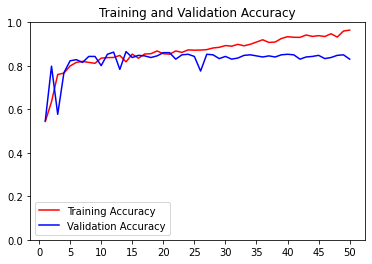

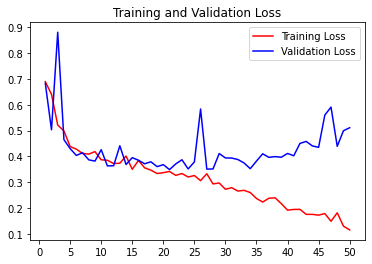

In [ ]:
"""
MODEL 1_1_A PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted in order to 
find possible cases of overfitting.
"""

plot_training_validation_accuracy(model1_1_a_history.history['accuracy'], model1_1_a_history.history['val_accuracy'])

plot_training_validation_loss(model1_1_a_history.history['loss'], model1_1_a_history.history['val_loss'])

As shown, it is clear that the model starts to overfit after 15-20 epochs. Training accuracy still continues to improve while validation accuracy remains approximately constant, meaning that the model is not learning anymore. It is also confirmed by the fact the validation loss function stops decreasing while the training loss function continues.

### MODEL 1_1_B
This model is simply the stacking of 3 Convolutional layers, each one followed by a Max Pooling layer. There is a final Fully Connected layer, followed by another one used for the final classification. The total number of weights is higher than the ones of Model_1_1_a, and for that reason the training is slower. Once again *Relu* is used as activation function in Convolutional layers, while *Sigmoid* is used in the last Fully Connected layer. 





In [ ]:
"""
MODEL 1_1_B CREATION
"""

model1_1_b = models.Sequential(name="MODEL1_1_B")
model1_1_b.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
model1_1_b.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_1"))
model1_1_b.add(layers.Conv2D(filters=96, kernel_size=(2,2), activation='relu', name="CONV_2"))
model1_1_b.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_2"))
model1_1_b.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_3"))
model1_1_b.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_3"))
model1_1_b.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_4"))
model1_1_b.add(layers.MaxPooling2D(pool_size=(3,3), name="MAX_POOL_4"))
model1_1_b.add(layers.Flatten(name="FLAT_1"))
model1_1_b.add(layers.Dense(units=1024, activation='relu', name="DENSE_1"))
model1_1_b.add(layers.Dense(units=1, activation='sigmoid', name="DENSE_2"))

model1_1_b.summary()

Model: "MODEL1_1_B"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 74, 74, 64)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 73, 73, 96)        24672     
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 36, 36, 96)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 34, 34, 192)       166080    
_________________________________________________________________
MAX_POOL_3 (MaxPooling2D)    (None, 17, 17, 192)       0         
_________________________________________________________________
CONV_4 (Conv2D)              (None, 15, 15, 192)       3

In [ ]:
"""
MODEL 1_1_B COMPILATION AND FITTING
A predefined set of Hyperparameters is used for compiling the model (Adam+1e-4 as
optimizer, binary_crossentropy as loss function) and for training it (32 as
batch size, 50 as epochs, 0.15 as validation_split).
"""

model1_1_b.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1_1_b_history = model1_1_b.fit(x=m1_1_training_images,
          y=m1_1_training_labels, 
          epochs=DEFAULT_NUMBER_OF_EPOCHS,
          batch_size=DEFAULT_BATCH_SIZE,
          validation_split=VALIDATION_SPLIT,
          shuffle=True)

Epoch 1/50
72/72 [==============================] - 4s 44ms/step - loss: 0.6914 - accuracy: 0.5415 - val_loss: 0.6783 - val_accuracy: 0.5498
Epoch 2/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6763 - accuracy: 0.5796 - val_loss: 0.6596 - val_accuracy: 0.5871
Epoch 3/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6484 - accuracy: 0.6168 - val_loss: 0.6145 - val_accuracy: 0.5721
Epoch 4/50
72/72 [==============================] - 3s 39ms/step - loss: 0.5831 - accuracy: 0.7016 - val_loss: 0.5013 - val_accuracy: 0.7040
Epoch 5/50
72/72 [==============================] - 3s 39ms/step - loss: 0.5171 - accuracy: 0.7584 - val_loss: 0.4802 - val_accuracy: 0.7960
Epoch 6/50
72/72 [==============================] - 3s 39ms/step - loss: 0.5366 - accuracy: 0.7594 - val_loss: 0.4474 - val_accuracy: 0.8209
Epoch 7/50
72/72 [==============================] - 3s 40ms/step - loss: 0.4225 - accuracy: 0.8216 - val_loss: 0.4022 - val_accuracy: 0.8408
Epoch 8/50
72

In [ ]:
"""
MODEL 1_1_B RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m1_1_b_test_loss, m1_1_b_test_accuracy = model1_1_b.evaluate(m1_1_test_images ,m1_1_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m1_1_b_test_accuracy))
print("LOSS " + str(m1_1_b_test_loss))

11/11 [==============================] - 0s 23ms/step - loss: 0.4109 - accuracy: 0.8512
TEST SET RESULTS
ACCURACY 0.851190447807312
LOSS 0.41094285249710083


The result is even better than the one obtained from model_1_1_a (85% vs. 80%).

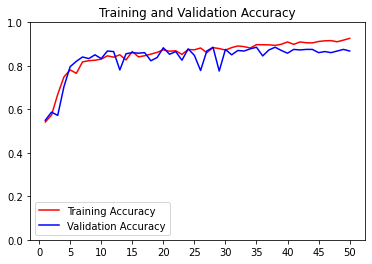

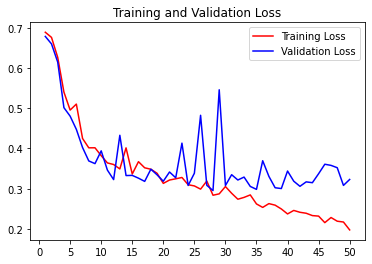

In [ ]:
"""
MODEL 1_1_B PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted in order to 
find possible cases of overfitting.
"""

plot_training_validation_accuracy(model1_1_b_history.history['accuracy'], model1_1_b_history.history['val_accuracy'])

plot_training_validation_loss(model1_1_b_history.history['loss'], model1_1_b_history.history['val_loss'])

Once again, the model starts to overfit after 20-25 epochs.

###MODEL 1_1_C
This model is obtained by stacking more Convolutional blocks, each one composed by two Convolutional layers and a single Max Pooling layer. This idea is similar to the one adopted in *VGG* networks. *Padding=same* combined with *stride=1* ensure that the output of a Convolutional layer has the same shape of the input, so shape reduction is performed only by means of Max Pooling layers. Three Dense layers are finally added to the model. Once again, *Relu* is used as Activation function in Convolutional layers and *Sigmoid* in the last Fully Connected layer.

In [ ]:
"""
MODEL 1_1_C CREATION
"""

model1_1_c = models.Sequential(name="MODEL1_1_C")
model1_1_c.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding="same", input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
model1_1_c.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_1"))
model1_1_c.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same", name="CONV_2"))
model1_1_c.add(layers.MaxPooling2D(pool_size=(3,3), padding="same", name="MAX_POOL_2"))
model1_1_c.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu', name="CONV_3"))
model1_1_c.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu', name="CONV_4"))
model1_1_c.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_3"))
model1_1_c.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu', name="CONV_5"))
model1_1_c.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu', name="CONV_6"))
model1_1_c.add(layers.MaxPooling2D(pool_size=(2,2), padding="same", name="MAX_POOL_4"))
model1_1_c.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu', name="CONV_7"))
model1_1_c.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu', name="CONV_8"))
model1_1_c.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_5"))
model1_1_c.add(layers.Flatten(name="FLAT_1"))
model1_1_c.add(layers.Dense(units=1024, activation='relu', name="DENSE_1"))
model1_1_c.add(layers.Dense(units=1024, activation='relu', name="DENSE_2"))
model1_1_c.add(layers.Dense(units=1, activation='sigmoid', name="DENSE_3"))

model1_1_c.summary()

Model: "MODEL1_1_C"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 75, 75, 32)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 75, 75, 64)        18496     
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 25, 25, 64)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 25, 25, 128)       73856     
_________________________________________________________________
CONV_4 (Conv2D)              (None, 25, 25, 128)       147584    
_________________________________________________________________
MAX_POOL_3 (MaxPooling2D)    (None, 12, 12, 128)       0

In [ ]:
"""
MODEL 1_1_C COMPILATION AND FITTING
A predefined set of Hyperparameters is used for compiling the model (Adam+1e-4 as
optimizer, binary_crossentropy as loss function) and for training it (32 as
batch size, 50 as epochs, 0.15 as validation_split).
"""

model1_1_c.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1_1_c_history = model1_1_c.fit(x=m1_1_training_images,
          y=m1_1_training_labels, 
          epochs=DEFAULT_NUMBER_OF_EPOCHS,
          batch_size=DEFAULT_BATCH_SIZE,
          validation_split=VALIDATION_SPLIT,
          shuffle=True)

Epoch 1/50
72/72 [==============================] - 3s 36ms/step - loss: 0.6919 - accuracy: 0.5540 - val_loss: 0.6872 - val_accuracy: 0.5473
Epoch 2/50
72/72 [==============================] - 2s 32ms/step - loss: 0.6798 - accuracy: 0.5606 - val_loss: 0.6671 - val_accuracy: 0.7114
Epoch 3/50
72/72 [==============================] - 2s 32ms/step - loss: 0.6547 - accuracy: 0.6276 - val_loss: 0.7838 - val_accuracy: 0.6095
Epoch 4/50
72/72 [==============================] - 2s 32ms/step - loss: 0.5373 - accuracy: 0.7569 - val_loss: 0.4606 - val_accuracy: 0.7886
Epoch 5/50
72/72 [==============================] - 2s 33ms/step - loss: 0.4555 - accuracy: 0.7833 - val_loss: 0.4524 - val_accuracy: 0.7960
Epoch 6/50
72/72 [==============================] - 2s 32ms/step - loss: 0.4532 - accuracy: 0.8076 - val_loss: 0.3822 - val_accuracy: 0.8408
Epoch 7/50
72/72 [==============================] - 2s 33ms/step - loss: 0.3719 - accuracy: 0.8442 - val_loss: 0.3644 - val_accuracy: 0.8458
Epoch 8/50
72

In [ ]:
"""
MODEL 1_1_C RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m1_1_c_test_loss, m1_1_c_test_accuracy = model1_1_c.evaluate(m1_1_test_images ,m1_1_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m1_1_c_test_accuracy))
print("LOSS " + str(m1_1_c_test_loss))

11/11 [==============================] - 0s 13ms/step - loss: 1.1326 - accuracy: 0.8452
TEST SET RESULTS
ACCURACY 0.8452380895614624
LOSS 1.1326402425765991


The results are good (accuracy is slightly lower than in model1_1_b).

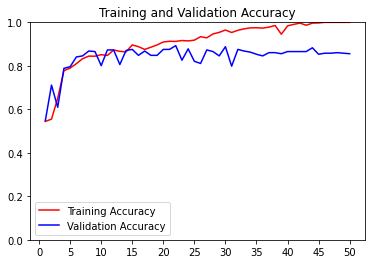

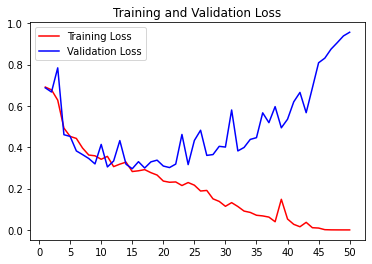

In [ ]:
"""
MODEL 1_1_C PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted in order to 
find possible cases of overfitting.
"""

plot_training_validation_accuracy(model1_1_c_history.history['accuracy'], model1_1_c_history.history['val_accuracy'])

plot_training_validation_loss(model1_1_c_history.history['loss'], model1_1_c_history.history['val_loss'])

The model starts to overfit after 15 epochs. So it requires less epochs to learn, but the capability to generalize is lower than the one obtained in the previous model. The main difference with previous models is that validation loss function starts increasing after reaching the minimum, while validation accuracy remains constant. This can mean that samples with already bad predictions keep getting worse (for example, the output for a sample of class 1 passes from 0.4 to 0.2 ).

###CONCLUSIONS
The three models presents an accuracy on the test set of 80%, 85% and 84% respectively. Model1_1_b seems to be the better because of its high accuracy and low loss function, so it is one considered for next experiments. Model1_1_c presents a good accuracy value, but loss function is much higher than the other models. It is useful to save the best model and its results on the test set. 


In [ ]:
best_model1 = model1_1_b
best_accuracy1 = m1_1_b_test_accuracy
best_loss1 = m1_1_b_test_loss

##EXPERIMENT 1_2: EARLY STOPPING, DROPOUT, DATA AUGMENTATION
Since the model starts to overfit after 20-25, an Early Stopping strategy can be adopted to stop the training when the validation loss stops decreasing. In order to mitigate the problem, a Dropout layer can be added too. Finally, another experiment that can be perfomed is trying to augment the data.

In [ ]:
"""
PREPROCESSING: SPLIT TRAINING - VALIDATION SETS
In order to further create data generators, training and validation set are splitted
in advance. Training and test images are normalized. Training images (and their respective labels) are 
shuffled because the parameter validation_split of model.fit function will take the last portion 
of the dataset as validation set. To the current state, images (and their labels) are ordered by 
class (the elements labelled as 0 are at the end of the set). Since the same permutation of 
experiment 1_1 is used, class distribution is the same of the previous experiment. 

"""

m1_2_training_images = training_images / MAX_UINT16
m1_2_training_labels = cm_training_labels

m1_2_test_images = test_images / MAX_UINT16
m1_2_test_labels = cm_test_labels

# permutation is used in order to perform the same shuffling on images and labels
permutation = np.random.RandomState(seed=SEED).permutation(TRAINING_SET_SIZE)   
m1_2_training_images = m1_2_training_images[permutation]  
m1_2_training_labels = m1_2_training_labels[permutation] 

# analyze the composition of the validation set
m1_2_validation_size = int(np.floor(TRAINING_SET_SIZE*VALIDATION_SPLIT))
m1_2_training_size = TRAINING_SET_SIZE-m1_2_validation_size
m1_2_validation_images = m1_2_training_images[-m1_2_validation_size:]
m1_2_validation_labels = m1_2_training_labels[-m1_2_validation_size:]

m1_2_training_images = m1_2_training_images[:m1_2_training_size]
m1_2_training_labels = m1_2_training_labels[:m1_2_training_size]

### DROPOUT AND EARLY STOPPING
A Dropout layer is added just before the first Fully Connected layer. Its dropout rate is set to 0.3. A callback is defined in order to implement an Early Stopping strategy: training is stopped after 5 epochs with no improvement on validation loss function, and weights corresponding to the minimum validation loss step are restored. 

In [ ]:
"""
MODEL 1_2_DE CREATION
"""

model1_2_de = models.Sequential(name="MODEL1_2_DE")
model1_2_de.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
model1_2_de.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_1"))
model1_2_de.add(layers.Conv2D(filters=96, kernel_size=(2,2), activation='relu', name="CONV_2"))
model1_2_de.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_2"))
model1_2_de.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_3"))
model1_2_de.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_3"))
model1_2_de.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_4"))
model1_2_de.add(layers.MaxPooling2D(pool_size=(3,3), name="MAX_POOL_4"))
model1_2_de.add(layers.Flatten(name="FLAT_1"))
model1_2_de.add(layers.Dropout(rate=0.3, name="DROP_1"))
model1_2_de.add(layers.Dense(units=1024, activation='relu', name="DENSE_1"))
model1_2_de.add(layers.Dense(units=1, activation='sigmoid', name="DENSE_2"))

model1_2_de.summary()

Model: "MODEL1_2_DE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 74, 74, 64)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 73, 73, 96)        24672     
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 36, 36, 96)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 34, 34, 192)       166080    
_________________________________________________________________
MAX_POOL_3 (MaxPooling2D)    (None, 17, 17, 192)       0         
_________________________________________________________________
CONV_4 (Conv2D)              (None, 15, 15, 192)       

In [ ]:
"""
MODEL 1_2_DE CALLBACK DEFINITION
"""
callback = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
"""
MODEL 1_2_DE COMPILATION AND FITTING
A predefined set of Hyperparameters is used for compiling the model (Adam+1e-4 as
optimizer, binary_crossentropy as loss function) and for training it (32 as
batch size, 50 as epochs).
"""

model1_2_de.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1_2_de_history  = model1_2_de.fit(x=m1_2_training_images,
          y=m1_2_training_labels,
          validation_data=(m1_2_validation_images, m1_2_validation_labels), 
          callbacks=[callback],
          batch_size=DEFAULT_BATCH_SIZE,
          epochs=DEFAULT_NUMBER_OF_EPOCHS)

Epoch 1/50
72/72 [==============================] - 3s 41ms/step - loss: 0.6931 - accuracy: 0.5276 - val_loss: 0.7033 - val_accuracy: 0.5486
Epoch 2/50
72/72 [==============================] - 3s 38ms/step - loss: 0.6919 - accuracy: 0.5603 - val_loss: 0.6741 - val_accuracy: 0.5411
Epoch 3/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6722 - accuracy: 0.5676 - val_loss: 0.6082 - val_accuracy: 0.5885
Epoch 4/50
72/72 [==============================] - 3s 39ms/step - loss: 0.5919 - accuracy: 0.6953 - val_loss: 0.4903 - val_accuracy: 0.7506
Epoch 5/50
72/72 [==============================] - 3s 38ms/step - loss: 0.4991 - accuracy: 0.7720 - val_loss: 0.4551 - val_accuracy: 0.8155
Epoch 6/50
72/72 [==============================] - 3s 39ms/step - loss: 0.4506 - accuracy: 0.8074 - val_loss: 0.4071 - val_accuracy: 0.8254
Epoch 7/50
72/72 [==============================] - 3s 39ms/step - loss: 0.4350 - accuracy: 0.8138 - val_loss: 0.4438 - val_accuracy: 0.7955
Epoch 8/50
72

In [ ]:
"""
MODEL 1_2_DE RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m1_2_de_test_loss, m1_2_de_test_accuracy = model1_2_de.evaluate(m1_2_test_images ,m1_2_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m1_2_de_test_accuracy))
print("LOSS " + str(m1_2_de_test_loss))

11/11 [==============================] - 0s 16ms/step - loss: 0.3428 - accuracy: 0.8750
TEST SET RESULTS
ACCURACY 0.875
LOSS 0.3427850604057312


These are the best results achieved so far.

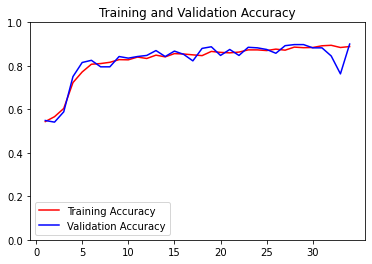

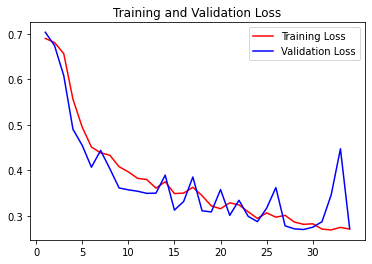

In [ ]:
"""
MODEL 1_2_DE PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted.
"""

plot_training_validation_accuracy(model1_2_de_history.history['accuracy'], model1_2_de_history.history['val_accuracy'])

plot_training_validation_loss(model1_2_de_history.history['loss'], model1_2_de_history.history['val_loss'])

The model doesn't overfit anymore. 

###DATA AUGMENTATION
Another experiment that can be performed is Data Augmentation. The model used is the one with the Dropout layer (see last paragraph). An Early Stopping mechanism is used too. 

In [ ]:
"""
CREATION OF DATA GENERATORS
Data generators for training and validation are created. Training and validation
images are already normalized. Images of the training set are rescaled. 
"""

m1_2_training_datagenerator = ImageDataGenerator(
    rotation_range=90
)

m1_2_training_generator = m1_2_training_datagenerator.flow(x=m1_2_training_images, y=m1_2_training_labels)

m1_2_validation_datagenerator = ImageDataGenerator()

m1_2_validation_generator = m1_2_validation_datagenerator.flow(x=m1_2_validation_images, y=m1_2_validation_labels)

In [ ]:
"""
MODEL 1_2_DA CREATION
"""

model1_2_da = models.Sequential(name="MODEL1_2_DA")
model1_2_da.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
model1_2_da.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_1"))
model1_2_da.add(layers.Conv2D(filters=96, kernel_size=(2,2), activation='relu', name="CONV_2"))
model1_2_da.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_2"))
model1_2_da.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_3"))
model1_2_da.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_3"))
model1_2_da.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_4"))
model1_2_da.add(layers.MaxPooling2D(pool_size=(3,3), name="MAX_POOL_4"))
model1_2_da.add(layers.Flatten(name="FLAT_1"))
model1_2_da.add(layers.Dropout(rate=0.3, name="DROP_1"))
model1_2_da.add(layers.Dense(units=1024, activation='relu', name="DENSE_1"))
model1_2_da.add(layers.Dense(units=1, activation='sigmoid', name="DENSE_2"))

model1_2_da.summary()

Model: "MODEL1_2_DA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 74, 74, 64)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 73, 73, 96)        24672     
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 36, 36, 96)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 34, 34, 192)       166080    
_________________________________________________________________
MAX_POOL_3 (MaxPooling2D)    (None, 17, 17, 192)       0         
_________________________________________________________________
CONV_4 (Conv2D)              (None, 15, 15, 192)       

In [ ]:
"""
MODEL 1_2_DA CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
"""
MODEL 1_2_DA COMPILATION AND FITTING
"""

model1_2_da.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1_2_da_history  = model1_2_da.fit(x=m1_2_training_generator,
          validation_data=m1_2_validation_generator , 
          steps_per_epoch=m1_2_training_size//DEFAULT_BATCH_SIZE,
          validation_steps=m1_2_validation_size//DEFAULT_BATCH_SIZE,
          callbacks=[callback],
          epochs=DEFAULT_NUMBER_OF_EPOCHS)

Epoch 1/50
71/71 [==============================] - 5s 65ms/step - loss: 0.6910 - accuracy: 0.5480 - val_loss: 0.6817 - val_accuracy: 0.5521
Epoch 2/50
71/71 [==============================] - 5s 63ms/step - loss: 0.6814 - accuracy: 0.5733 - val_loss: 0.6410 - val_accuracy: 0.6745
Epoch 3/50
71/71 [==============================] - 4s 63ms/step - loss: 0.6473 - accuracy: 0.6299 - val_loss: 0.6042 - val_accuracy: 0.7448
Epoch 4/50
71/71 [==============================] - 5s 63ms/step - loss: 0.5764 - accuracy: 0.7506 - val_loss: 0.4768 - val_accuracy: 0.7943
Epoch 5/50
71/71 [==============================] - 4s 63ms/step - loss: 0.4806 - accuracy: 0.7925 - val_loss: 0.4774 - val_accuracy: 0.8021
Epoch 6/50
71/71 [==============================] - 5s 63ms/step - loss: 0.4958 - accuracy: 0.7722 - val_loss: 0.4446 - val_accuracy: 0.7812
Epoch 7/50
71/71 [==============================] - 5s 63ms/step - loss: 0.4321 - accuracy: 0.8189 - val_loss: 0.4169 - val_accuracy: 0.8229
Epoch 8/50
71

In [ ]:
"""
MODEL 1_2_DA RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m1_2_da_test_loss, m1_2_da_test_accuracy = model1_2_da.evaluate(m1_2_test_images ,m1_2_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m1_2_da_test_accuracy))
print("LOSS " + str(m1_2_da_test_loss))

11/11 [==============================] - 0s 16ms/step - loss: 0.3703 - accuracy: 0.8393
TEST SET RESULTS
ACCURACY 0.8392857313156128
LOSS 0.3702671527862549


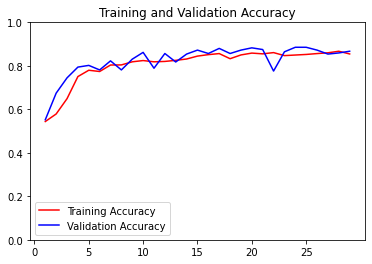

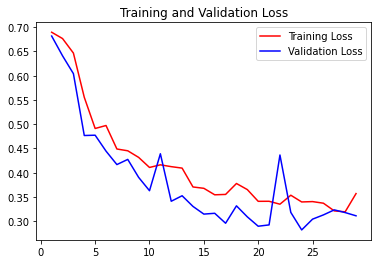

In [ ]:
"""
MODEL 1_2_DA PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted.
"""

plot_training_validation_accuracy(model1_2_da_history.history['accuracy'], model1_2_da_history.history['val_accuracy'])

plot_training_validation_loss(model1_2_da_history.history['loss'], model1_2_da_history.history['val_loss'])

### CONCLUSIONS
The Dropout+Early Stopping experiments led to a slight improvement (85% to 86%). However, performing data augmentation led did not enhance the results. 

In [ ]:
best_model1 = model1_2_de
best_accuracy1 = m1_2_de_test_accuracy
best_loss1 = m1_2_de_test_loss

##EXPERIMENT 1_3: HYPERPARAMETERS TUNING AND OTHER OPTIMIZATIONS
A grid search can be useful to find the best hyperparameters configurations. For each of them, possible values are chosen in accord with papers (see report) and laboratory experience. Max number of epochs is increased to 200 because lower learning rates are used. For the same reason, patience in callback is increased. Glorot Uniform and He Uniform are used as kernel initializers for ReLu-based layers and Sigmoid-based layers respectively. WARNING: very slow.



In [ ]:
"""
PREPROCESSING
Since no data augmentation is used, training and test images are normalized. Training images 
(and their respective labels) are shuffled because the parameter validation_split of model.fit 
function will take the last portion of the dataset as validation set. To the current state, 
images (and their labels) are ordered by class (the elements labelled as 0 are at the end of the set). 
Since the permutation used is the same of previous experiments, validation set 
distribution is always the same (not printed).
"""

m1_3_training_images = training_images / MAX_UINT16
m1_3_training_labels = cm_training_labels

m1_3_test_images = test_images / MAX_UINT16
m1_3_test_labels = cm_test_labels

# permutation is used in order to perform the same shuffling on images and labels
permutation = np.random.RandomState(seed=SEED).permutation(TRAINING_SET_SIZE)   
m1_3_training_images = m1_3_training_images[permutation]  
m1_3_training_labels = m1_3_training_labels[permutation] 

m1_3_validation_size = int(np.floor(TRAINING_SET_SIZE*VALIDATION_SPLIT))

In [ ]:
"""
FUNCTION DEFINITION
This function is used to build model b considering the dropout rate as 
parameter. The function is used for parameters optimization.
"""

def build_model(dropout_rate):
  
  model = models.Sequential(name="MODEL")
  model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer="he_uniform", input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
  model.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_1"))
  model.add(layers.Conv2D(filters=96, kernel_size=(2,2), activation='relu', kernel_initializer="he_uniform", name="CONV_2"))
  model.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_2"))
  model.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', kernel_initializer="he_uniform", name="CONV_3"))
  model.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_3"))
  model.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', kernel_initializer="he_uniform", name="CONV_4"))
  model.add(layers.MaxPooling2D(pool_size=(3,3), name="MAX_POOL_4"))
  model.add(layers.Flatten(name="FLAT_1"))
  model.add(layers.Dropout(rate=dropout_rate, name="DROP_1"))
  model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="he_uniform", name="DENSE_1"))
  model.add(layers.Dense(units=1, activation='sigmoid', kernel_initializer="glorot_uniform", name="DENSE_2"))

  return model


In [ ]:
"""
CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
"""
MODEL 1_3 GRID SEARCH
"""

optimizers_names = ["Adam", "RMSprop", "SGD"]
learning_rates = [1e-4, 1e-5, 1e-6]
batch_sizes = [16, 32]
dropout_rates = [0.3, 0.4, 0.5]

for optimizer_name in optimizers_names:
  for learning_rate in learning_rates:
    for batch_size in batch_sizes:
      for dropout_rate in dropout_rates:
      
        model = build_model(dropout_rate)

        optimizer_obj = tf.keras.optimizers.get(optimizer_name)
        optimizer_obj.learning_rate.assign(learning_rate)

        model.compile(optimizer=optimizer_obj,
                loss='binary_crossentropy',
                metrics=['accuracy'])

        model_history = model.fit(x=m1_3_training_images,
            y=m1_3_training_labels, 
            epochs=MAX_NUMBER_OF_EPOCHS,
            batch_size=batch_size,
            validation_split=VALIDATION_SPLIT,
            shuffle=True,
            callbacks=[callback],
            verbose=0)
        
        test_loss, test_accuracy = model.evaluate(m1_3_test_images ,m1_3_test_labels, verbose=0)
        print("MODEL RECAP: LEARNING RATE " + str(learning_rate) + ", OPTIMIZER " + optimizer_name + ", BATCH SIZE " + str(batch_size) +", DROPOUT RATE " + str(dropout_rate) )
        print("ACCURACY " + str(test_accuracy))
        print("LOSS " + str(test_loss))

        if test_loss<best_loss1 and test_accuracy<best_accuracy1:

          best_model1 = model
          best_accuracy1 = test_accuracy
          best_loss1 = test_loss

MODEL RECAP: LEARNING RATE 0.0001, OPTIMIZER Adam, BATCH SIZE 16, DROPOUT RATE 0.3
ACCURACY 0.8482142686843872
LOSS 0.4269357919692993
MODEL RECAP: LEARNING RATE 0.0001, OPTIMIZER Adam, BATCH SIZE 16, DROPOUT RATE 0.4
ACCURACY 0.8482142686843872
LOSS 0.47237178683280945
MODEL RECAP: LEARNING RATE 0.0001, OPTIMIZER Adam, BATCH SIZE 16, DROPOUT RATE 0.5
ACCURACY 0.8333333134651184
LOSS 0.4385627508163452
MODEL RECAP: LEARNING RATE 0.0001, OPTIMIZER Adam, BATCH SIZE 32, DROPOUT RATE 0.3
ACCURACY 0.8273809552192688
LOSS 0.433734267950058
MODEL RECAP: LEARNING RATE 0.0001, OPTIMIZER Adam, BATCH SIZE 32, DROPOUT RATE 0.4
ACCURACY 0.8452380895614624
LOSS 0.3834737241268158
MODEL RECAP: LEARNING RATE 0.0001, OPTIMIZER Adam, BATCH SIZE 32, DROPOUT RATE 0.5
ACCURACY 0.8541666865348816
LOSS 0.38751402497291565
MODEL RECAP: LEARNING RATE 1e-05, OPTIMIZER Adam, BATCH SIZE 16, DROPOUT RATE 0.3
ACCURACY 0.8392857313156128
LOSS 0.38638854026794434
MODEL RECAP: LEARNING RATE 1e-05, OPTIMIZER Adam, BATC

Results varies in a small range (0.35-0.5 for loss function, 0.79-0.85 for accuracy) when optimizer is *Adam* or *RMSprop*. Best result is still the one of Model1_2, with Dropout and Early Stopping and without Data Augmentation.

###CONCLUSIONS
The best model is Model1_2_de. It uses Dropout, Early Stopping but not Data Augmentation. It reaches an accuracy of 87.5% on the test set and the loss function arrives at 0.34. 

##MODEL SAVING

In [ ]:
"""
SAVE THE MODEL
Best model is saved in model folder as 'calcification_mass_scratch'.
"""

best_model1.save(os.path.join(MODELS_FOLDER,"calcification_mass_scratch.h5"))

#SUBTASK 2: FROM-SCRATCH BENIGN-MALIGNANT CLASSIFICATION
Since the problem is a binary classification, we need to distinguish between two classes. Label 0 is assigned to Benign class (original labels were 1 and 3), label 1 is assigned to Malignant class (original labels were 2 and 4). It is important to analyze the balancing of the two classes so that a countermeasure to a possible unbalanced class problem can be taken.

In [ ]:
"""
PREPROCESSING
Labels are redefined: label 0 is assigned to Benign class, label 1 is assigned to 
Malignant class. Sets compositions are printed.
"""

bm_training_labels = np.array([0 if n%2==1 else 1 for n in training_labels])
bm_test_labels = np.array([0 if n%2==1 else 1 for n in test_labels])

# analyze composition of training and test set
print("TRAINING SET")
print("Number of samples of class 0 (Benign): " + str(np.count_nonzero(bm_training_labels==0)) + 
      " (" + str(round((np.count_nonzero(bm_training_labels==0)/TRAINING_SET_SIZE)*100,2)) + "%)")
print("Number of samples of class 1 (Malignant): " + str(np.count_nonzero(bm_training_labels==1)) + 
      " (" + str(round((np.count_nonzero(bm_training_labels==1)/TRAINING_SET_SIZE)*100,2)) + "%)")

print("TEST SET")
print("Number of samples of class 0 (Benign): " + str(np.count_nonzero(bm_test_labels==0)) + 
      " (" + str(round((np.count_nonzero(bm_test_labels==0)/TEST_SET_SIZE)*100,2)) + "%)")
print("Number of samples of class 1 (Malignant): " + str(np.count_nonzero(bm_test_labels==1)) + 
      " (" + str(round((np.count_nonzero(bm_test_labels==1)/TEST_SET_SIZE)*100,2)) + "%)")

best_model2 = None
best_accuracy2 = 0
best_loss2 = 100

TRAINING SET
Number of samples of class 0 (Benign): 1568 (58.59%)
Number of samples of class 1 (Malignant): 1108 (41.41%)
TEST SET
Number of samples of class 0 (Benign): 219 (65.18%)
Number of samples of class 1 (Malignant): 117 (34.82%)


As shown, training set and test set are only slightly unbalanced. This little unbalance should not affect network performance. 

##EXPERIMENT 2_1: TRY THE MODELS OF THE PREVIOUS SUBTASK
The aim of this experiment is to evaluate if the already created models are suitable for the new problem. The experiment is perfomed without data augmentation, early stopping and regularization and with a fixed set of hyperparameters (batch_size=32, number_of_epochs=50, optimizer=Adam, learning_rate=1e-4). Binary Crossentropy is used as loss function.

In [ ]:
"""
PREPROCESSING
Training and test images are normalized. Training images (and their respective labels) are 
shuffled even if classes are already randomly distributed. Validation set composition is
printed, so that a new extraction can be performed in case of unbalanced classes.
"""

m2_1_training_images = training_images / MAX_UINT16
m2_1_training_labels = bm_training_labels

m2_1_test_images = test_images / MAX_UINT16
m2_1_test_labels = bm_test_labels

# permutation is used in order to perform the same shuffling on images and labels
permutation = np.random.RandomState(seed=SEED).permutation(TRAINING_SET_SIZE)   
m2_1_training_images = m2_1_training_images[permutation]  
m2_1_training_labels = m2_1_training_labels[permutation] 

# analyze the composition of the validation set
m2_1_validation_size = int(np.floor(TRAINING_SET_SIZE*VALIDATION_SPLIT))
m2_1_validation_labels = m2_1_training_labels[-m2_1_validation_size:]

print("VALIDATION SET")
print("Number of samples of class 0 (Benign): " + str(np.count_nonzero(m2_1_validation_labels==0)) + 
      " (" + str(round((np.count_nonzero(m2_1_validation_labels==0)/m2_1_validation_size)*100,2)) + "%)")
print("Number of samples of class 1 (Malignant): " + str(np.count_nonzero(m2_1_validation_labels==1)) + 
      " (" + str(round((np.count_nonzero(m2_1_validation_labels==1)/m2_1_validation_size)*100,2)) + "%)")

VALIDATION SET
Number of samples of class 0 (Benign): 252 (62.84%)
Number of samples of class 1 (Malignant): 149 (37.16%)


### MODEL 2_1_A
It is the same model defined in Model 1_1_A paragraph.

In [ ]:
"""
MODEL 1_1_A CREATION
"""

model2_1_a = models.Sequential(name="MODEL2_1_A")
model2_1_a.add(layers.Conv2D(filters=32, kernel_size=(9,9), strides=3, activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
model2_1_a.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="MAX_POOL_1"))
model2_1_a.add(layers.Conv2D(filters=96, kernel_size=(5,5), padding="same", activation='relu', name="CONV_2"))
model2_1_a.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="MAX_POOL_2"))
model2_1_a.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', name="CONV_3"))
model2_1_a.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', name="CONV_4"))
model2_1_a.add(layers.Conv2D(filters=96, kernel_size=(3, 3), padding="same", activation='relu', name="CONV_5"))
model2_1_a.add(layers.MaxPooling2D(pool_size=(3, 3), strides=2, name="MAX_POOL_3"))
model2_1_a.add(layers.Flatten(name="FLAT_1"))
model2_1_a.add(layers.Dense(units=256, activation='relu', name="DENSE_1"))
model2_1_a.add(layers.Dense(units=256, activation='relu', name="DENSE_2"))
model2_1_a.add(layers.Dense(units=1, activation='sigmoid', name="DENSE_3"))

model2_1_a.summary()

Model: "MODEL2_1_A"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 48, 48, 32)        2624      
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 24, 24, 32)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 24, 24, 96)        76896     
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 12, 12, 96)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 12, 12, 128)       110720    
_________________________________________________________________
CONV_4 (Conv2D)              (None, 12, 12, 128)       147584    
_________________________________________________________________
CONV_5 (Conv2D)              (None, 12, 12, 96)        1

In [ ]:
"""
MODEL 2_1_A COMPILATION AND FITTING
A predefined set of Hyperparameters is used for compiling the model (Adam+1e-4 as
optimizer, binary_crossentropy as loss function) and for training it (32 as
batch size, 50 as epochs, 0.15 as validation_split).
"""

model2_1_a.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2_1_a_history = model2_1_a.fit(x=m2_1_training_images,
          y=m2_1_training_labels, 
          epochs=DEFAULT_NUMBER_OF_EPOCHS,
          batch_size=DEFAULT_BATCH_SIZE,
          validation_split=VALIDATION_SPLIT,
          shuffle=True)

Epoch 1/50
72/72 [==============================] - 9s 17ms/step - loss: 0.6900 - accuracy: 0.5718 - val_loss: 0.6713 - val_accuracy: 0.6294
Epoch 2/50
72/72 [==============================] - 1s 9ms/step - loss: 0.6871 - accuracy: 0.5669 - val_loss: 0.6700 - val_accuracy: 0.6294
Epoch 3/50
72/72 [==============================] - 1s 9ms/step - loss: 0.6831 - accuracy: 0.5720 - val_loss: 0.6718 - val_accuracy: 0.6294
Epoch 4/50
72/72 [==============================] - 1s 9ms/step - loss: 0.6742 - accuracy: 0.5947 - val_loss: 0.6633 - val_accuracy: 0.6294
Epoch 5/50
72/72 [==============================] - 1s 9ms/step - loss: 0.6833 - accuracy: 0.5810 - val_loss: 0.6554 - val_accuracy: 0.6393
Epoch 6/50
72/72 [==============================] - 1s 9ms/step - loss: 0.6650 - accuracy: 0.6039 - val_loss: 0.6806 - val_accuracy: 0.5423
Epoch 7/50
72/72 [==============================] - 1s 9ms/step - loss: 0.6595 - accuracy: 0.6026 - val_loss: 0.6180 - val_accuracy: 0.6716
Epoch 8/50
72/72 [=

In [ ]:
"""
MODEL 2_1_A RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m2_1_a_test_loss, m2_1_a_test_accuracy = model2_1_a.evaluate(m2_1_test_images ,m2_1_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m2_1_a_test_accuracy))
print("LOSS " + str(m2_1_a_test_loss))

11/11 [==============================] - 0s 10ms/step - loss: 0.7909 - accuracy: 0.6071
TEST SET RESULTS
ACCURACY 0.6071428656578064
LOSS 0.7908810377120972


Results are not so good: loss function is high and accuracy is only slightly better than 0.5. However, they are in line with the ones found in Tsochatzidis' paper.

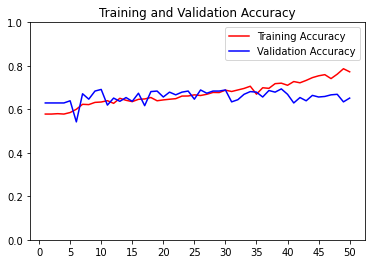

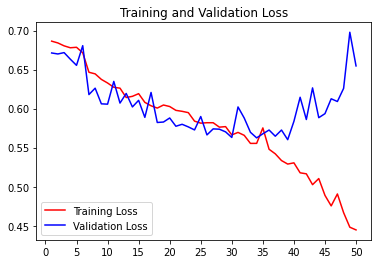

In [ ]:
"""
MODEL 2_1_A PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted in order to 
find possible cases of overfitting.
"""

plot_training_validation_accuracy(model2_1_a_history.history['accuracy'], model2_1_a_history.history['val_accuracy'])

plot_training_validation_loss(model2_1_a_history.history['loss'], model2_1_a_history.history['val_loss'])

The model starts to overfit after 30 epochs: it is clear because training loss function decrease while validation loss increase, meaning that the model stopped learning. As in the case of Model1_1_c, validation loss increases while validation accuracy is approximately constant. This means that already samples with already bad predictions keep getting worse.

### MODEL 2_1_B
It is the same model defined in Model 1_1_B paragraph.

In [ ]:
"""
MODEL 2_1_B CREATION
"""

model2_1_b = models.Sequential(name="MODEL2_1_B")
model2_1_b.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
model2_1_b.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_1"))
model2_1_b.add(layers.Conv2D(filters=96, kernel_size=(2,2), activation='relu', name="CONV_2"))
model2_1_b.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_2"))
model2_1_b.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_3"))
model2_1_b.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_3"))
model2_1_b.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_4"))
model2_1_b.add(layers.MaxPooling2D(pool_size=(3,3), name="MAX_POOL_4"))
model2_1_b.add(layers.Flatten(name="FLAT_1"))
model2_1_b.add(layers.Dense(units=1024, activation='relu', name="DENSE_1"))
model2_1_b.add(layers.Dense(units=1, activation='sigmoid', name="DENSE_2"))

model2_1_b.summary()

Model: "MODEL2_1_B"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 74, 74, 64)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 73, 73, 96)        24672     
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 36, 36, 96)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 34, 34, 192)       166080    
_________________________________________________________________
MAX_POOL_3 (MaxPooling2D)    (None, 17, 17, 192)       0         
_________________________________________________________________
CONV_4 (Conv2D)              (None, 15, 15, 192)       3

In [ ]:
"""
MODEL 2_1_B COMPILATION AND FITTING
A predefined set of Hyperparameters is used for compiling the model (Adam+1e-4 as
optimizer, binary_crossentropy as loss function) and for training it (32 as
batch size, 50 as epochs, 0.15 as validation_split).
"""

model2_1_b.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2_1_b_history = model2_1_b.fit(x=m2_1_training_images,
          y=m2_1_training_labels, 
          epochs=DEFAULT_NUMBER_OF_EPOCHS,
          batch_size=DEFAULT_BATCH_SIZE,
          validation_split=VALIDATION_SPLIT,
          shuffle=True)

Epoch 1/50
72/72 [==============================] - 4s 46ms/step - loss: 0.6926 - accuracy: 0.5551 - val_loss: 0.6678 - val_accuracy: 0.6294
Epoch 2/50
72/72 [==============================] - 3s 42ms/step - loss: 0.6862 - accuracy: 0.5669 - val_loss: 0.6573 - val_accuracy: 0.6294
Epoch 3/50
72/72 [==============================] - 3s 40ms/step - loss: 0.6795 - accuracy: 0.5829 - val_loss: 0.6727 - val_accuracy: 0.6468
Epoch 4/50
72/72 [==============================] - 3s 41ms/step - loss: 0.6523 - accuracy: 0.6141 - val_loss: 0.6352 - val_accuracy: 0.6542
Epoch 5/50
72/72 [==============================] - 3s 41ms/step - loss: 0.6340 - accuracy: 0.6303 - val_loss: 0.6391 - val_accuracy: 0.6244
Epoch 6/50
72/72 [==============================] - 3s 41ms/step - loss: 0.6227 - accuracy: 0.6326 - val_loss: 0.6268 - val_accuracy: 0.6318
Epoch 7/50
72/72 [==============================] - 3s 41ms/step - loss: 0.6194 - accuracy: 0.6382 - val_loss: 0.6141 - val_accuracy: 0.6468
Epoch 8/50
72

In [ ]:
"""
MODEL 2_1_B RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m2_1_b_test_loss, m2_1_b_test_accuracy = model2_1_b.evaluate(m2_1_test_images ,m2_1_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m2_1_b_test_accuracy))
print("LOSS " + str(m2_1_b_test_loss))

11/11 [==============================] - 0s 27ms/step - loss: 0.8725 - accuracy: 0.6607
TEST SET RESULTS
ACCURACY 0.6607142686843872
LOSS 0.8725296854972839


Results are slightly better than Model2_1_a: accuracy is higher (67% vs. 60%) but loss function is higher (0.87 vs. 0.79). 

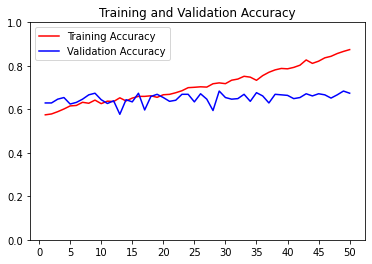

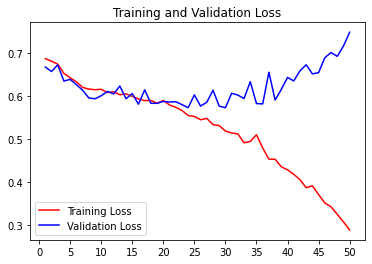

In [ ]:
"""
MODEL 2_1_B PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted in order to 
find possible cases of overfitting.
"""

plot_training_validation_accuracy(model2_1_b_history.history['accuracy'], model2_1_b_history.history['val_accuracy'])

plot_training_validation_loss(model2_1_b_history.history['loss'], model2_1_b_history.history['val_loss'])

Once again, the model overfits after 25 epochs. Validation loss increases probably because already wrong classified samples keep getting worse.  

###MODEL 2_1_C
It is the same model defined in Model 1_1_C paragraph.

In [ ]:
"""
MODEL 2_1_C CREATION
"""

model2_1_c = models.Sequential(name="MODEL2_1_C")
model2_1_c.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding="same", input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
model2_1_c.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_1"))
model2_1_c.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same", name="CONV_2"))
model2_1_c.add(layers.MaxPooling2D(pool_size=(3,3), padding="same", name="MAX_POOL_2"))
model2_1_c.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu', name="CONV_3"))
model2_1_c.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu', name="CONV_4"))
model2_1_c.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_3"))
model2_1_c.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu', name="CONV_5"))
model2_1_c.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu', name="CONV_6"))
model2_1_c.add(layers.MaxPooling2D(pool_size=(2,2), padding="same", name="MAX_POOL_4"))
model2_1_c.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu', name="CONV_7"))
model2_1_c.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu', name="CONV_8"))
model2_1_c.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_5"))
model2_1_c.add(layers.Flatten(name="FLAT_1"))
model2_1_c.add(layers.Dense(units=1024, activation='relu', name="DENSE_1"))
model2_1_c.add(layers.Dense(units=1024, activation='relu', name="DENSE_2"))
model2_1_c.add(layers.Dense(units=1, activation='sigmoid', name="DENSE_3"))

model2_1_c.summary()

Model: "MODEL2_1_C"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 75, 75, 32)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 75, 75, 64)        18496     
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 25, 25, 64)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 25, 25, 128)       73856     
_________________________________________________________________
CONV_4 (Conv2D)              (None, 25, 25, 128)       147584    
_________________________________________________________________
MAX_POOL_3 (MaxPooling2D)    (None, 12, 12, 128)       0

In [ ]:
"""
MODEL 2_1_C COMPILATION AND FITTING
A predefined set of Hyperparameters is used for compiling the model (Adam+1e-4 as
optimizer, binary_crossentropy as loss function) and for training it (32 as
batch size, 50 as epochs, 0.15 as validation_split).
"""

model2_1_c.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2_1_c_history = model2_1_c.fit(x=m2_1_training_images,
          y=m2_1_training_labels, 
          epochs=DEFAULT_NUMBER_OF_EPOCHS,
          batch_size=DEFAULT_BATCH_SIZE,
          validation_split=VALIDATION_SPLIT,
          shuffle=True)

Epoch 1/50
72/72 [==============================] - 4s 38ms/step - loss: 0.6901 - accuracy: 0.5718 - val_loss: 0.6669 - val_accuracy: 0.6294
Epoch 2/50
72/72 [==============================] - 2s 32ms/step - loss: 0.6868 - accuracy: 0.5669 - val_loss: 0.6674 - val_accuracy: 0.6294
Epoch 3/50
72/72 [==============================] - 2s 33ms/step - loss: 0.6824 - accuracy: 0.5718 - val_loss: 0.6751 - val_accuracy: 0.6294
Epoch 4/50
72/72 [==============================] - 2s 33ms/step - loss: 0.6792 - accuracy: 0.5934 - val_loss: 0.6539 - val_accuracy: 0.6294
Epoch 5/50
72/72 [==============================] - 2s 33ms/step - loss: 0.6809 - accuracy: 0.5779 - val_loss: 0.6720 - val_accuracy: 0.6269
Epoch 6/50
72/72 [==============================] - 2s 33ms/step - loss: 0.6599 - accuracy: 0.6001 - val_loss: 0.6603 - val_accuracy: 0.6542
Epoch 7/50
72/72 [==============================] - 2s 33ms/step - loss: 0.6741 - accuracy: 0.5846 - val_loss: 0.6485 - val_accuracy: 0.6493
Epoch 8/50
72

In [ ]:
"""
MODEL 2_1_C RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m2_1_c_test_loss, m2_1_c_test_accuracy = model2_1_c.evaluate(m2_1_test_images ,m2_1_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m2_1_c_test_accuracy))
print("LOSS " + str(m2_1_c_test_loss))

11/11 [==============================] - 0s 24ms/step - loss: 1.8299 - accuracy: 0.5923
TEST SET RESULTS
ACCURACY 0.5922619104385376
LOSS 1.829927921295166


Accuracy is lower than the one obtained in Model2_1_a (60%) and Model2_1_b (67%). However, loss function is much higher than the previous cases: this probably means that it the model is in an overfitting condition.

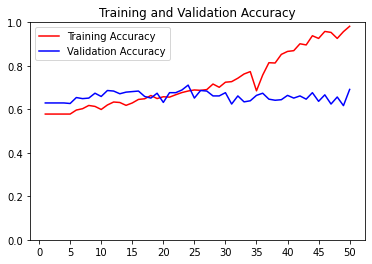

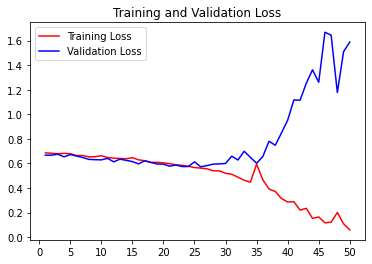

In [ ]:
"""
MODEL 2_1_C PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted in order to 
find possible cases of overfitting.
"""

plot_training_validation_accuracy(model2_1_c_history.history['accuracy'], model2_1_c_history.history['val_accuracy'])

plot_training_validation_loss(model2_1_c_history.history['loss'], model2_1_c_history.history['val_loss'])

As could be inferred from the previous consideration, the model is subjected to overfitting. Validation loss function stops decreasing after 25 epochs and then starts increasing quickly. 

###CONCLUSIONS
Results are not so good but they are approximately in line with the results found in the papers. As in Subtask 1, Model1_1_b is much better than the others so it is the one considered for next experiments.

In [ ]:
best_model2 = model2_1_b
best_accuracy2 = m2_1_b_test_accuracy 
best_loss2 = m2_1_b_test_loss

##EXPERIMENT 2_2: EARLY STOPPING, DROPOUT, DATA AUGMENTATION
Since the model starts to overfit after 20-25, an Early Stopping strategy can be adopted to stop the training when the validation loss stops decreasing. In order to mitigate the problem, a Dropout layer can be added too. Finally, another experiment that can be perfomed is trying to augment the data.

In [ ]:
"""
SPLIT TRAINING - VALIDATION
In order to further create data generators, training and validation set are splitted
in advance. Training and test images are normalized. Training images (and their respective labels) are 
shuffled because even if classes are already randomly distributed. Since the same permutation of 
experiment 1_1 is used, class distribution is the same of the previous experiment. 
"""

m2_2_training_images = training_images / MAX_UINT16
m2_2_training_labels = bm_training_labels

# permutation is used in order to perform the same shuffling on images and labels
permutation = np.random.RandomState(seed=SEED).permutation(TRAINING_SET_SIZE)   
m2_2_training_images = m2_2_training_images[permutation]  
m2_2_training_labels = m2_2_training_labels[permutation] 

# analyze the composition of the validation set
m2_2_validation_size = int(np.floor(TRAINING_SET_SIZE*VALIDATION_SPLIT))
m2_2_training_size = TRAINING_SET_SIZE-m2_2_validation_size
m2_2_validation_images = m2_2_training_images[-m2_2_validation_size:]
m2_2_validation_labels = m2_2_training_labels[-m2_2_validation_size:]

m2_2_training_images = m2_2_training_images[:m2_2_training_size]
m2_2_training_labels = m2_2_training_labels[:m2_2_training_size]

print("TRAINING SET")
print("Number of samples of class 0 (Benign): " + str(np.count_nonzero(m2_2_training_labels==0)) + 
      " (" + str(round((np.count_nonzero(m2_2_training_labels==0)/(TRAINING_SET_SIZE-m2_2_validation_size))*100,2)) + "%)")
print("Number of samples of class 1 (Malignant): " + str(np.count_nonzero(m2_2_training_labels==1)) + 
      " (" + str(round((np.count_nonzero(m2_2_training_labels==1)/(TRAINING_SET_SIZE-m2_2_validation_size))*100,2)) + "%)")

print("VALIDATION SET")
print("Number of samples of class 0 (Benign): " + str(np.count_nonzero(m2_2_validation_labels==0)) + 
      " (" + str(round((np.count_nonzero(m2_2_validation_labels==0)/m2_2_validation_size)*100,2)) + "%)")
print("Number of samples of class 1 (Malignant): " + str(np.count_nonzero(m2_2_validation_labels==1)) + 
      " (" + str(round((np.count_nonzero(m2_2_validation_labels==1)/m2_2_validation_size)*100,2)) + "%)")

# Test set is normalized
m2_2_test_images = test_images / MAX_UINT16
m2_2_test_labels = bm_test_labels

TRAINING SET
Number of samples of class 0 (Benign): 1316 (57.85%)
Number of samples of class 1 (Malignant): 959 (42.15%)
VALIDATION SET
Number of samples of class 0 (Benign): 252 (62.84%)
Number of samples of class 1 (Malignant): 149 (37.16%)


###DROPOUT AND EARLY STOPPING
A Dropout layer is added just before the first Fully Connected layer. Its dropout rate is set to 0.3. A callback is defined in order to implement an Early Stopping strategy: training is stopped after 5 epochs with no improvement on validation loss function, and weights corresponding to the minimum validation loss step are restored.

In [ ]:
"""
MODEL 2_2_DE CREATION
"""

model2_2_de = models.Sequential(name="MODEL2_2_DE")
model2_2_de.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
model2_2_de.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_1"))
model2_2_de.add(layers.Conv2D(filters=96, kernel_size=(2,2), activation='relu', name="CONV_2"))
model2_2_de.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_2"))
model2_2_de.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_3"))
model2_2_de.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_3"))
model2_2_de.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_4"))
model2_2_de.add(layers.MaxPooling2D(pool_size=(3,3), name="MAX_POOL_4"))
model2_2_de.add(layers.Flatten(name="FLAT_1"))
model2_2_de.add(layers.Dropout(rate=0.3, name="DROP_1"))
model2_2_de.add(layers.Dense(units=1024, activation='relu', name="DENSE_1"))
model2_2_de.add(layers.Dense(units=1, activation='sigmoid', name="DENSE_2"))

model2_2_de.summary()

Model: "MODEL2_2_DE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 74, 74, 64)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 73, 73, 96)        24672     
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 36, 36, 96)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 34, 34, 192)       166080    
_________________________________________________________________
MAX_POOL_3 (MaxPooling2D)    (None, 17, 17, 192)       0         
_________________________________________________________________
CONV_4 (Conv2D)              (None, 15, 15, 192)       

In [ ]:
"""
MODEL 2_2_DE CALLBACK DEFINITION
"""
callback = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
"""
MODEL 2_2_DE COMPILATION AND FITTING
A predefined set of Hyperparameters is used for compiling the model (Adam+1e-4 as
optimizer, binary_crossentropy as loss function) and for training it (32 as
batch size, 50 as epochs).
"""

model2_2_de.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2_2_de_history  = model2_2_de.fit(x=m2_2_training_images,
          y=m2_2_training_labels,
          validation_data=(m2_2_validation_images, m2_2_validation_labels), 
          callbacks=[callback],
          batch_size=DEFAULT_BATCH_SIZE,
          epochs=DEFAULT_NUMBER_OF_EPOCHS)

Epoch 1/50
72/72 [==============================] - 4s 45ms/step - loss: 0.6900 - accuracy: 0.5668 - val_loss: 0.6719 - val_accuracy: 0.6284
Epoch 2/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6904 - accuracy: 0.5641 - val_loss: 0.6630 - val_accuracy: 0.6284
Epoch 3/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6755 - accuracy: 0.5947 - val_loss: 0.6663 - val_accuracy: 0.6409
Epoch 4/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6707 - accuracy: 0.5861 - val_loss: 0.6136 - val_accuracy: 0.6608
Epoch 5/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6538 - accuracy: 0.6124 - val_loss: 0.6070 - val_accuracy: 0.6783
Epoch 6/50
72/72 [==============================] - 3s 40ms/step - loss: 0.6402 - accuracy: 0.6045 - val_loss: 0.6362 - val_accuracy: 0.6284
Epoch 7/50
72/72 [==============================] - 3s 40ms/step - loss: 0.6369 - accuracy: 0.6158 - val_loss: 0.6051 - val_accuracy: 0.6758
Epoch 8/50
72

In [ ]:
"""
MODEL 2_2_DE RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m2_2_de_test_loss, m2_2_de_test_accuracy = model2_2_de.evaluate(m2_2_test_images ,m2_2_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m2_2_de_test_accuracy))
print("LOSS " + str(m2_2_de_test_loss))

11/11 [==============================] - 0s 16ms/step - loss: 0.6018 - accuracy: 0.6756
TEST SET RESULTS
ACCURACY 0.675595223903656
LOSS 0.6018239855766296


Results are better than the ones of 'normal' case. Accuracy is slightly better (66% vs. 67%) while loss is definitely better (0.87 vs. 0.60).

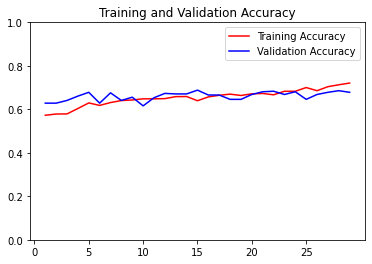

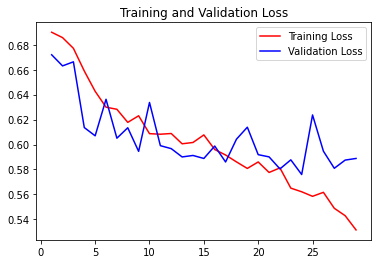

In [ ]:
"""
MODEL 2_2_DE PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted.
"""

plot_training_validation_accuracy(model2_2_de_history.history['accuracy'], model2_2_de_history.history['val_accuracy'])

plot_training_validation_loss(model2_2_de_history.history['loss'], model2_2_de_history.history['val_loss'])

###DATA AUGMENTATION
Another experiment that can be performed is Data Augmentation. The model used is the one with the Dropout layer (see last paragraph). An Early Stopping mechanism is used too.

In [ ]:
"""
CREATION OF DATA GENERATORS
Data generators for training and validation are created. Training and validation
images are already normalized. Images of the training set are rescaled. 
"""

m2_2_training_datagenerator = ImageDataGenerator(
    rotation_range=90,
)

m2_2_training_generator = m2_2_training_datagenerator.flow(x=m2_2_training_images, y=m2_2_training_labels)

m2_2_validation_datagenerator = ImageDataGenerator()

m2_2_validation_generator = m2_2_validation_datagenerator.flow(x=m2_2_validation_images, y=m2_2_validation_labels)

In [ ]:
"""
MODEL 2_2_DA CREATION
"""

model2_2_da = models.Sequential(name="MODEL2_2_DA")
model2_2_da.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
model2_2_da.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_1"))
model2_2_da.add(layers.Conv2D(filters=96, kernel_size=(2,2), activation='relu', name="CONV_2"))
model2_2_da.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_2"))
model2_2_da.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_3"))
model2_2_da.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_3"))
model2_2_da.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', name="CONV_4"))
model2_2_da.add(layers.MaxPooling2D(pool_size=(3,3), name="MAX_POOL_4"))
model2_2_da.add(layers.Flatten(name="FLAT_1"))
model2_2_da.add(layers.Dropout(rate=0.3, name="DROP_1"))
model2_2_da.add(layers.Dense(units=1024, activation='relu', name="DENSE_1"))
model2_2_da.add(layers.Dense(units=1, activation='sigmoid', name="DENSE_2"))

model2_2_da.summary()

Model: "MODEL2_2_DA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
MAX_POOL_1 (MaxPooling2D)    (None, 74, 74, 64)        0         
_________________________________________________________________
CONV_2 (Conv2D)              (None, 73, 73, 96)        24672     
_________________________________________________________________
MAX_POOL_2 (MaxPooling2D)    (None, 36, 36, 96)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 34, 34, 192)       166080    
_________________________________________________________________
MAX_POOL_3 (MaxPooling2D)    (None, 17, 17, 192)       0         
_________________________________________________________________
CONV_4 (Conv2D)              (None, 15, 15, 192)       

In [ ]:
"""
MODEL 2_2_DA COMPILATION AND FITTING
"""

model2_2_da.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2_2_da_history  = model2_2_da.fit(x=m2_2_training_generator,
          validation_data=m2_2_validation_generator , 
          steps_per_epoch=m2_2_training_size//DEFAULT_BATCH_SIZE,
          validation_steps=m2_2_validation_size//DEFAULT_BATCH_SIZE,
          callbacks=[callback],
          epochs=DEFAULT_NUMBER_OF_EPOCHS)

Epoch 1/50
71/71 [==============================] - 5s 69ms/step - loss: 0.6925 - accuracy: 0.5394 - val_loss: 0.6757 - val_accuracy: 0.6172
Epoch 2/50
71/71 [==============================] - 5s 66ms/step - loss: 0.6897 - accuracy: 0.5511 - val_loss: 0.6609 - val_accuracy: 0.6302
Epoch 3/50
71/71 [==============================] - 5s 64ms/step - loss: 0.6809 - accuracy: 0.5790 - val_loss: 0.6584 - val_accuracy: 0.6250
Epoch 4/50
71/71 [==============================] - 5s 64ms/step - loss: 0.6712 - accuracy: 0.5841 - val_loss: 0.6334 - val_accuracy: 0.6510
Epoch 5/50
71/71 [==============================] - 5s 65ms/step - loss: 0.6503 - accuracy: 0.6049 - val_loss: 0.6243 - val_accuracy: 0.6901
Epoch 6/50
71/71 [==============================] - 5s 65ms/step - loss: 0.6305 - accuracy: 0.6262 - val_loss: 0.6811 - val_accuracy: 0.5547
Epoch 7/50
71/71 [==============================] - 5s 65ms/step - loss: 0.6398 - accuracy: 0.6206 - val_loss: 0.6017 - val_accuracy: 0.6589
Epoch 8/50
71

In [ ]:
"""
MODEL 2_2_DA RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m2_2_da_test_loss, m2_2_da_test_accuracy = model2_2_da.evaluate(m2_2_test_images ,m2_2_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m2_2_da_test_accuracy))
print("LOSS " + str(m2_2_da_test_loss))

11/11 [==============================] - 0s 16ms/step - loss: 0.6159 - accuracy: 0.6369
TEST SET RESULTS
ACCURACY 0.636904776096344
LOSS 0.6158891320228577


The experiment led to no improvements in test set results.

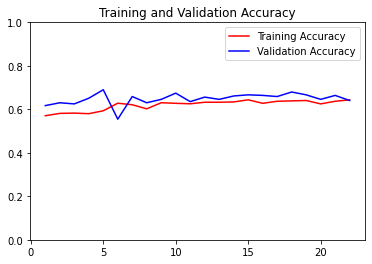

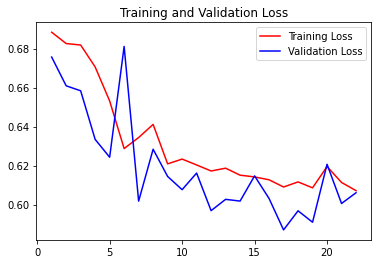

In [ ]:
"""
MODEL 2_2_DA PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted.
"""

plot_training_validation_accuracy(model2_2_da_history.history['accuracy'], model2_2_da_history.history['val_accuracy'])

plot_training_validation_loss(model2_2_da_history.history['loss'], model2_2_da_history.history['val_loss'])

###CONCLUSIONS
Model with Dropout and Early Stopping (but without Data Augmentation) is the best obtained so far for this problem. It is useful to save the model.

In [ ]:
best_model2 = model2_2_de
best_accuracy2 = m2_2_de_test_accuracy 
best_loss2 = m2_2_de_test_loss

##EXPERIMENT 2_3: HYPERPARAMETERS TUNING AND OTHER OPTIMIZATIONS
A grid search can be useful to find the best hyperparameters configurations. For each of them, possible values are chosen in accord with papers (see report) and laboratory experience. Max number of epochs is increased to 200 because lower learning rates are used. For the same reason, patience in callback is increased. Glorot Uniform and He Uniform are used as kernel initializers for ReLu-based layers and Sigmoid-based layers respectively. WARNING: very slow.

In [ ]:
"""
PREPROCESSING
Since no data augmentation is used, training and test images are normalized. Training images 
(and their respective labels) are shuffled because the parameter validation_split of model.fit 
function will take the last portion of the dataset as validation set. To the current state, 
images (and their labels) are ordered by class (the elements labelled as 0 are at the end of the set). 
Since the permutation used is the same of previous experiments, validation set 
distribution is always the same (not printed).
"""

m2_3_training_images = training_images / MAX_UINT16
m2_3_training_labels = bm_training_labels

m2_3_test_images = test_images / MAX_UINT16
m2_3_test_labels = bm_test_labels

# permutation is used in order to perform the same shuffling on images and labels
permutation = np.random.RandomState(seed=SEED).permutation(TRAINING_SET_SIZE)   
m2_3_training_images = m2_3_training_images[permutation]  
m2_3_training_labels = m2_3_training_labels[permutation] 

m2_3_validation_size = int(np.floor(TRAINING_SET_SIZE*VALIDATION_SPLIT))

In [ ]:
"""
FUNCTION DEFINITION
This function is used to build model b considering the dropout rate as 
parameter. The function is used for parameters optimization.
"""

def build_model(dropout_rate):
  
  model = models.Sequential(name="MODEL")
  model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer="he_uniform", input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), name="CONV_1"))
  model.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_1"))
  model.add(layers.Conv2D(filters=96, kernel_size=(2,2), activation='relu', kernel_initializer="he_uniform", name="CONV_2"))
  model.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_2"))
  model.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', kernel_initializer="he_uniform", name="CONV_3"))
  model.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_POOL_3"))
  model.add(layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', kernel_initializer="he_uniform", name="CONV_4"))
  model.add(layers.MaxPooling2D(pool_size=(3,3), name="MAX_POOL_4"))
  model.add(layers.Flatten(name="FLAT_1"))
  model.add(layers.Dropout(rate=dropout_rate, name="DROP_1"))
  model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="he_uniform", name="DENSE_1"))
  model.add(layers.Dense(units=1, activation='sigmoid', kernel_initializer="glorot_uniform", name="DENSE_2"))

  return model

In [ ]:
"""
CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
"""
MODEL 2_3 GRID SEARCH
"""

optimizers_names = ["Adam", "RMSprop", "SGD"]
learning_rates = [1e-4, 1e-5, 1e-6]
batch_sizes = [16, 32]
dropout_rates = [0.3, 0.4, 0.5]

for optimizer_name in optimizers_names:
  for learning_rate in learning_rates:
    for batch_size in batch_sizes:
      for dropout_rate in dropout_rates:
      
        model = build_model(dropout_rate)

        optimizer_obj = tf.keras.optimizers.get(optimizer_name)
        optimizer_obj.learning_rate.assign(learning_rate)

        model.compile(optimizer=optimizer_obj,
                loss='binary_crossentropy',
                metrics=['accuracy'])

        model_history = model.fit(x=m2_3_training_images,
            y=m2_3_training_labels, 
            epochs=MAX_NUMBER_OF_EPOCHS,
            batch_size=batch_size,
            validation_split=VALIDATION_SPLIT,
            shuffle=True,
            callbacks=[callback],
            verbose=0)
        
        test_loss, test_accuracy = model.evaluate(m2_3_test_images ,m2_3_test_labels, verbose=0)
        print("MODEL RECAP: LEARNING RATE " + str(learning_rate) + ", OPTIMIZER " + optimizer_name + ", BATCH SIZE " + str(batch_size) +", DROPOUT RATE " + str(dropout_rate) )
        print("ACCURACY " + str(test_accuracy))
        print("LOSS " + str(test_loss))

        if test_loss<best_loss2 and test_accuracy<best_accuracy2:

          best_model2 = model
          best_accuracy2 = test_accuracy
          best_loss2 = test_loss

MODEL RECAP: LEARNING RATE 0.0001, OPTIMIZER Adam, BATCH SIZE 16, DROPOUT RATE 0.3
ACCURACY 0.5922619104385376
LOSS 0.637604296207428
MODEL RECAP: LEARNING RATE 0.0001, OPTIMIZER Adam, BATCH SIZE 16, DROPOUT RATE 0.4
ACCURACY 0.636904776096344
LOSS 0.6528050303459167
MODEL RECAP: LEARNING RATE 0.0001, OPTIMIZER Adam, BATCH SIZE 16, DROPOUT RATE 0.5
ACCURACY 0.6577380895614624
LOSS 0.6298765540122986
MODEL RECAP: LEARNING RATE 0.0001, OPTIMIZER Adam, BATCH SIZE 32, DROPOUT RATE 0.3
ACCURACY 0.648809552192688
LOSS 0.6155619621276855
MODEL RECAP: LEARNING RATE 0.0001, OPTIMIZER Adam, BATCH SIZE 32, DROPOUT RATE 0.4
ACCURACY 0.6696428656578064
LOSS 0.6235837936401367
MODEL RECAP: LEARNING RATE 0.0001, OPTIMIZER Adam, BATCH SIZE 32, DROPOUT RATE 0.5
ACCURACY 0.6577380895614624
LOSS 0.6284289360046387
MODEL RECAP: LEARNING RATE 1e-05, OPTIMIZER Adam, BATCH SIZE 16, DROPOUT RATE 0.3
ACCURACY 0.6666666865348816
LOSS 0.5954301357269287
MODEL RECAP: LEARNING RATE 1e-05, OPTIMIZER Adam, BATCH SIZ

###CONCLUSIONS
More models reach similar results to the best model so far. Sometimes accuracy is better and sometimes loss is better, but not both at the same time. So the already developed model (Model 2_2_de) can still be considered the best one. 

##MODEL SAVING

In [ ]:
"""
SAVE THE MODEL
Best model is saved in model folder as 'benign_malignant_scratch'.
"""

best_model2.save(os.path.join(MODELS_FOLDER,"benign_malignant_scratch.h5"))